In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import exploring_script as es
import importlib
importlib.reload(es)
import pandas as pd
import swifter
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from swifter import set_defaults
set_defaults(
    npartitions=None,
    dask_threshold=1,
    scheduler="processes",
    progress_bar=True,
    progress_bar_desc=None,
    allow_dask_on_strings=False,
    force_parallel=True,
)

In [4]:
confirmed_sso = es.load_data(columns=["ssnamenr", "ra", "dec", "jd", "nid"])

In [6]:
prep_speed_gb = confirmed_sso.sort_values("jd").groupby("ssnamenr").agg(list)

In [7]:
speed_sso = prep_speed_gb.swifter.apply(es.sep_df, axis=1)

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

In [8]:
speed_sso = speed_sso.explode().replace([np.inf], np.nan).dropna().reset_index(drop=True)

/home/roman/anaconda3/envs/fink_fat_env/lib/python3.7/site-packages/swifter/swifter.py:88: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  "This pandas object has duplicate indices, "


### Solar System Object Speed Distribution

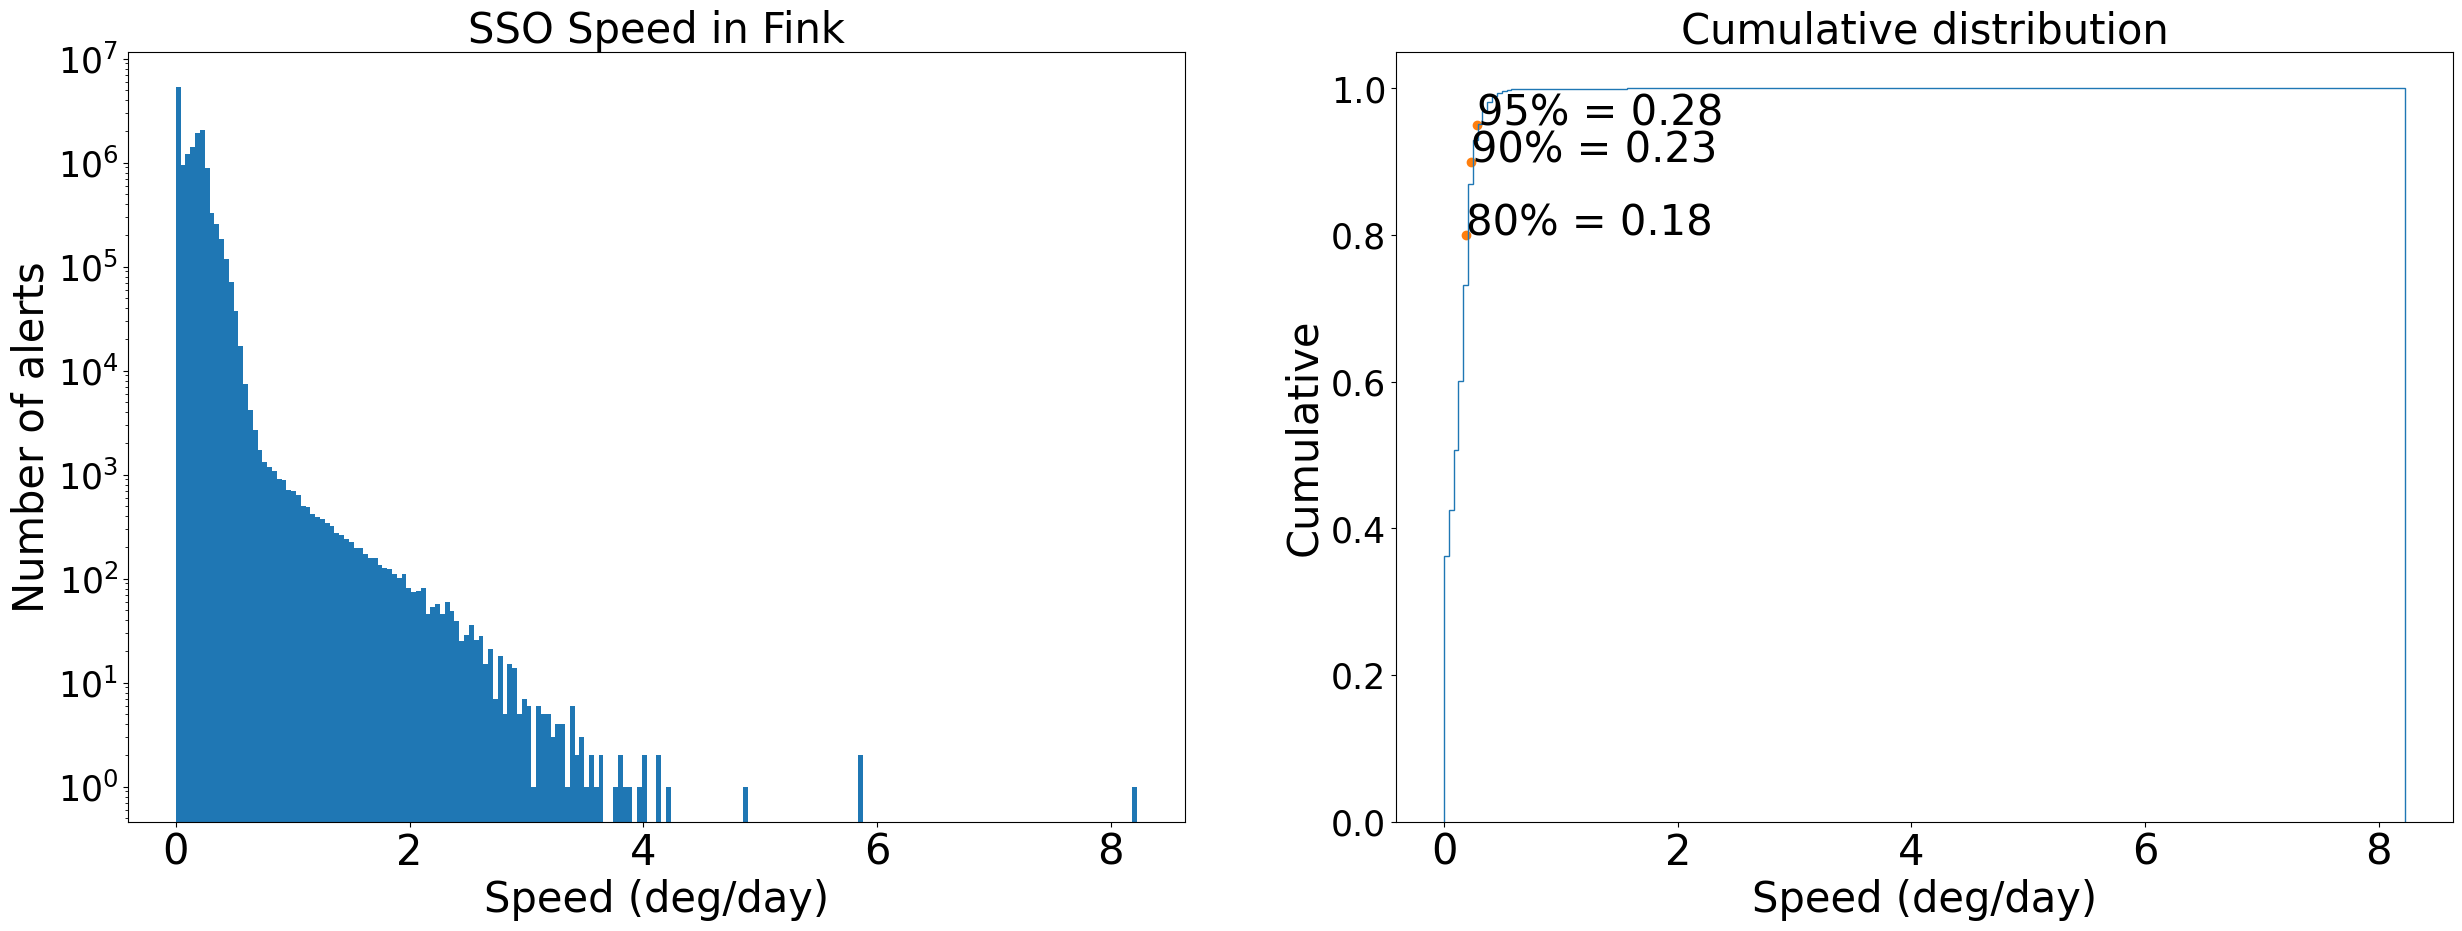

In [12]:
es.plot_hist_and_cdf(speed_sso, None, "SSO Speed in Fink", "Speed (deg/day)", "Number of alerts", None, "Cumulative distribution", "Speed (deg/day)", "Cumulative", percent_cdf=[0.8, 0.9, 0.95])

### Solar System Object Intra-night separation

In [49]:
prep_sep_gb = confirmed_sso.sort_values("jd").groupby(["nid", "ssnamenr"]).agg(
    ra=("ra", list),
    dec=("dec", list),
    jd=("jd", list),
    nb_obs=("ra", len)
)

In [50]:
prep_sep = prep_sep_gb[prep_sep_gb["nb_obs"] > 1].reset_index()

In [58]:
prep_sep_limit = prep_sep.sample(int(3e5), random_state=1)

In [59]:
intra_night_sep = prep_sep_limit.swifter.apply(es.intra_sep_df, axis=1)

Pandas Apply:   0%|          | 0/300000 [00:00<?, ?it/s]

In [60]:
speed_intra_sso = intra_night_sep.explode().replace([np.inf], np.nan).dropna().reset_index(drop=True)

/home/roman/anaconda3/envs/fink_fat_env/lib/python3.7/site-packages/swifter/swifter.py:88: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  "This pandas object has duplicate indices, "


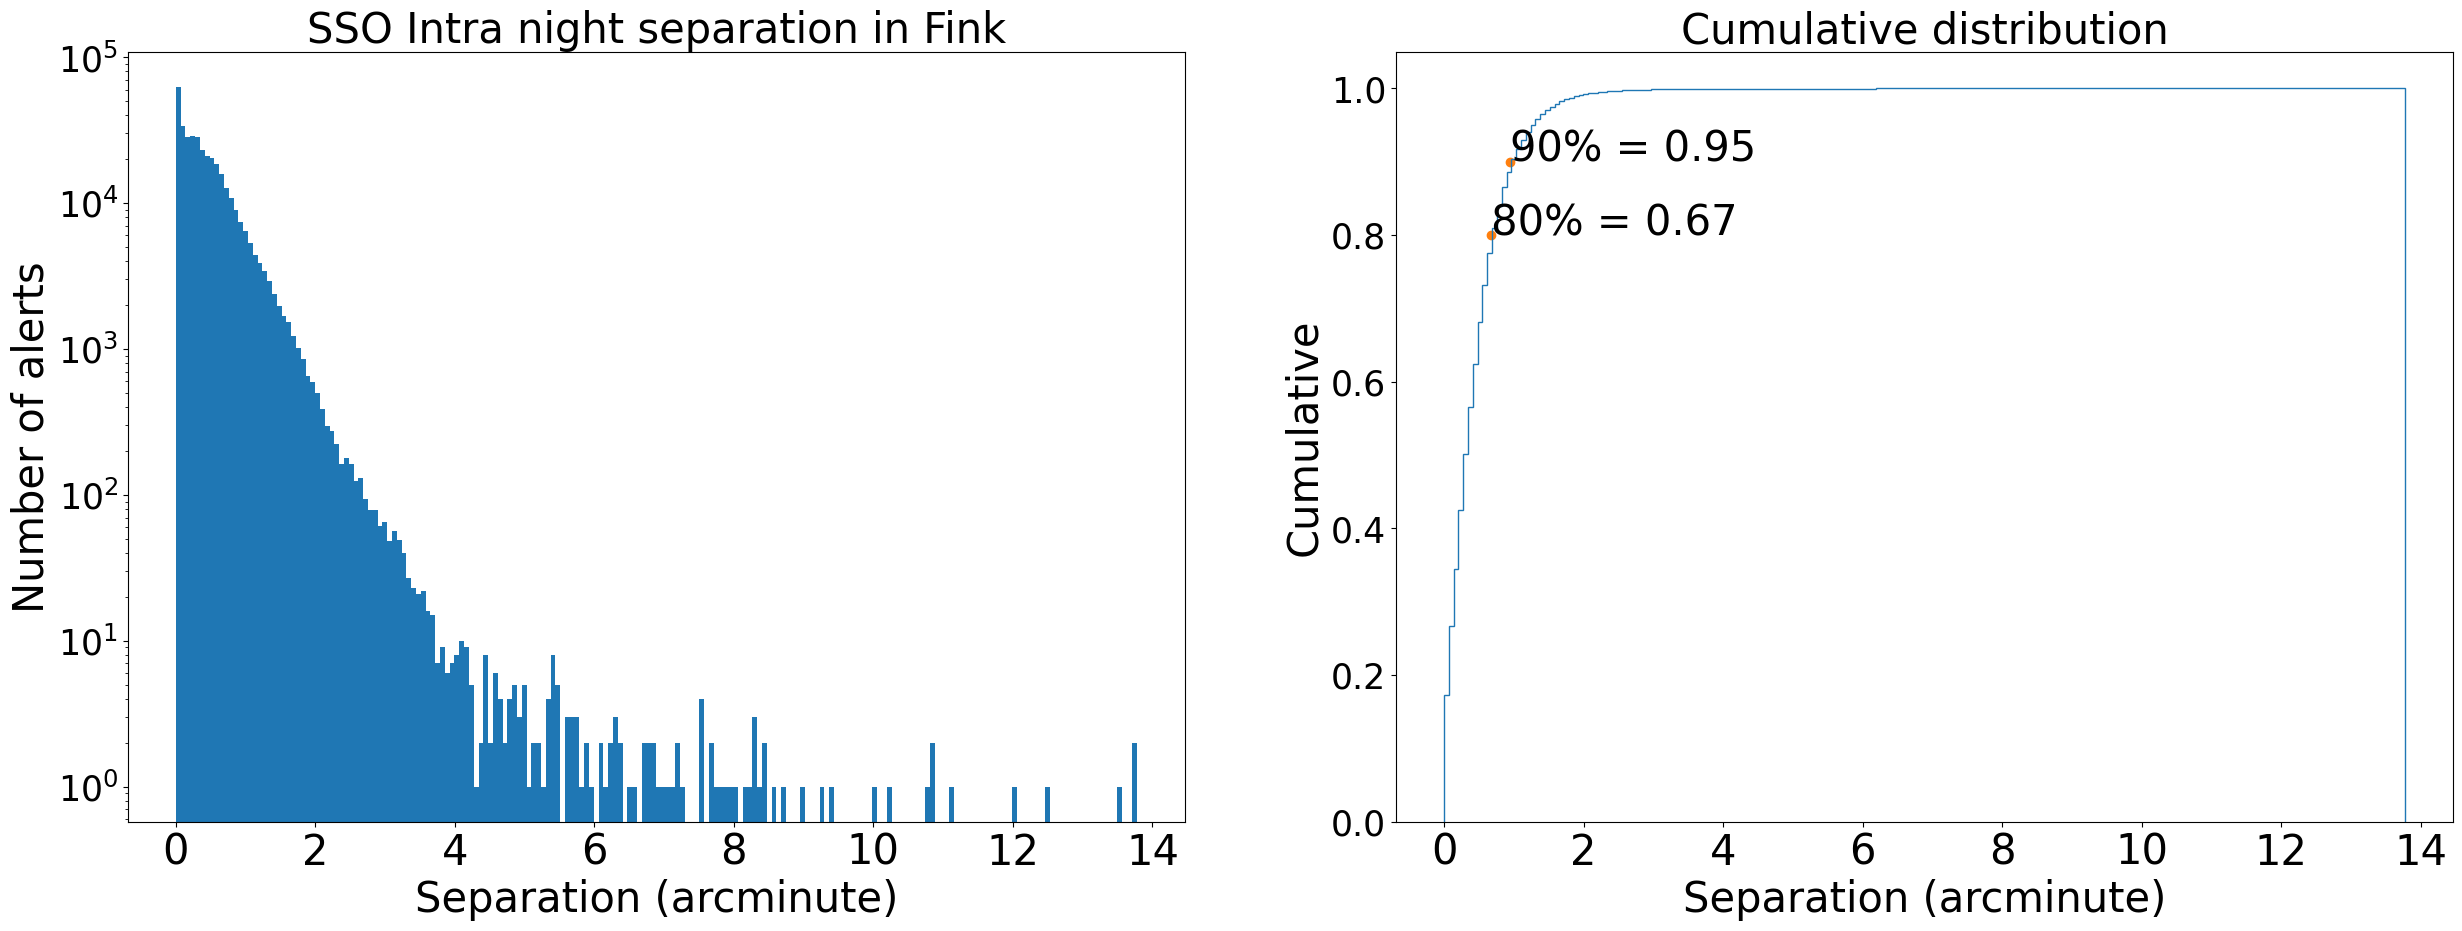

In [61]:
import matplotlib.pyplot as plt
es.plot_hist_and_cdf(speed_intra_sso, None, "SSO Intra night separation in Fink", "Separation (arcminute)", "Number of alerts", None, "Cumulative distribution", "Separation (arcminute)", "Cumulative")

### NEA Speed

##### Intra night

In [5]:
rocks_fink = pd.read_parquet("data/rocks_fink.parquet")
bft_sso = pd.read_parquet(
    "../data/BFT_Miriade/ssoBFT-latest.parquet",
    columns=[
        "sso_name", "sso_class", 
        "orbital_elements.inclination.value",
        "orbital_elements.semi_major_axis.value",
        "orbital_elements.eccentricity.value"
        ]
)

In [6]:
rocks_fink

,ast_name,ast_number
0,2003 UF205,461543.0
1,2001 FV155,46205.0
2,2001 HM5,46231.0
3,2008 UR120,462452.0
4,2001 HX20,46246.0
...,...,...
517606,2011 UT102,590221.0
517607,2017 XP64,594771.0
517608,2009 HV51,598907.0
517609,2002 CG264,619289.0


In [8]:
merge_bft_fink = bft_sso.merge(rocks_fink, left_on="sso_name", right_on="ast_name")

In [9]:
merge_bft_fink["ast_number"] = np.nan_to_num(merge_bft_fink["ast_number"], nan=-1.0).astype(int).astype("str")

In [10]:
nea_class = ["NEA>Amor", "NEA>Apollo", "NEA>Aten", "NEA>Atira"]

In [11]:
bft_nea = merge_bft_fink[merge_bft_fink["sso_class"].isin(nea_class)]

In [12]:
nea_fink = bft_nea.merge(confirmed_sso, left_on="ast_number", right_on="ssnamenr")

##### Speed (Inter + Intra)

In [13]:
prep_speed_gb_nea = nea_fink.sort_values("jd").groupby("ssnamenr").agg(list)

In [14]:
speed_nea = prep_speed_gb_nea.swifter.apply(es.sep_df, axis=1)

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

In [15]:
speed_nea = speed_nea.explode().replace([np.inf], np.nan).dropna().reset_index(drop=True)

/home/roman/anaconda3/envs/fink_fat_env/lib/python3.7/site-packages/swifter/swifter.py:88: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  "This pandas object has duplicate indices, "


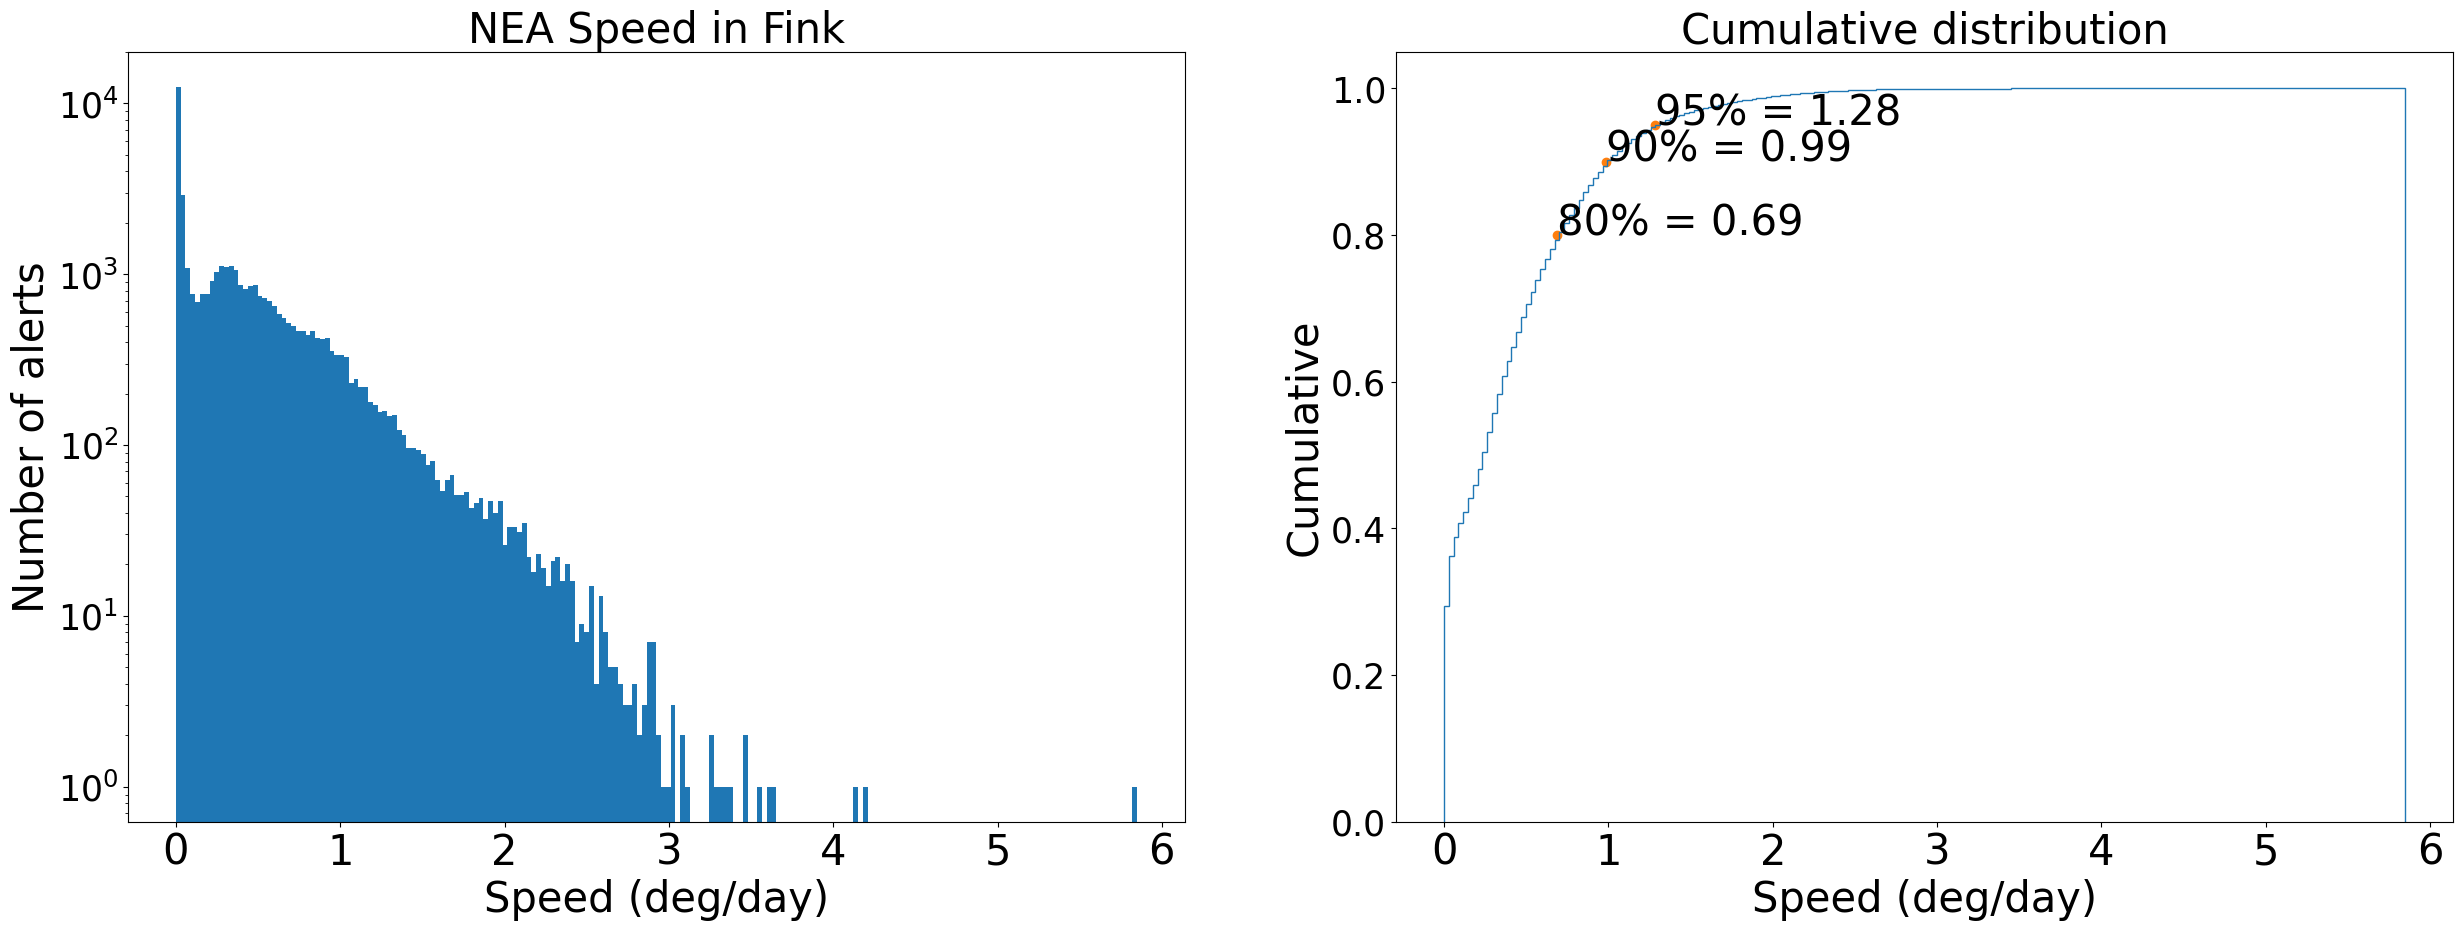

In [16]:
es.plot_hist_and_cdf(
    speed_nea, 
    None, 
    "NEA Speed in Fink", "Speed (deg/day)", 
    "Number of alerts", 
    None, 
    "Cumulative distribution", 
    "Speed (deg/day)", 
    "Cumulative", 
    percent_cdf=[0.8, 0.9, 0.95]
)

##### Speed (Only Intra)

In [17]:
prep_sep_gb_nea_intra = nea_fink.sort_values("jd").groupby(["nid", "ssnamenr"]).agg(
    ra=("ra", list),
    dec=("dec", list),
    jd=("jd", list),
    nb_obs=("ra", len)
)

In [19]:
prep_sep_nea_intra = prep_sep_gb_nea_intra[prep_sep_gb_nea_intra["nb_obs"] > 1].reset_index()

In [21]:
intra_night_sep_nea = prep_sep_nea_intra.swifter.apply(es.intra_sep_df, axis=1)

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

In [22]:
speed_intra_nea = intra_night_sep_nea.explode().replace([np.inf], np.nan).dropna().reset_index(drop=True)

/home/roman/anaconda3/envs/fink_fat_env/lib/python3.7/site-packages/swifter/swifter.py:88: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  "This pandas object has duplicate indices, "


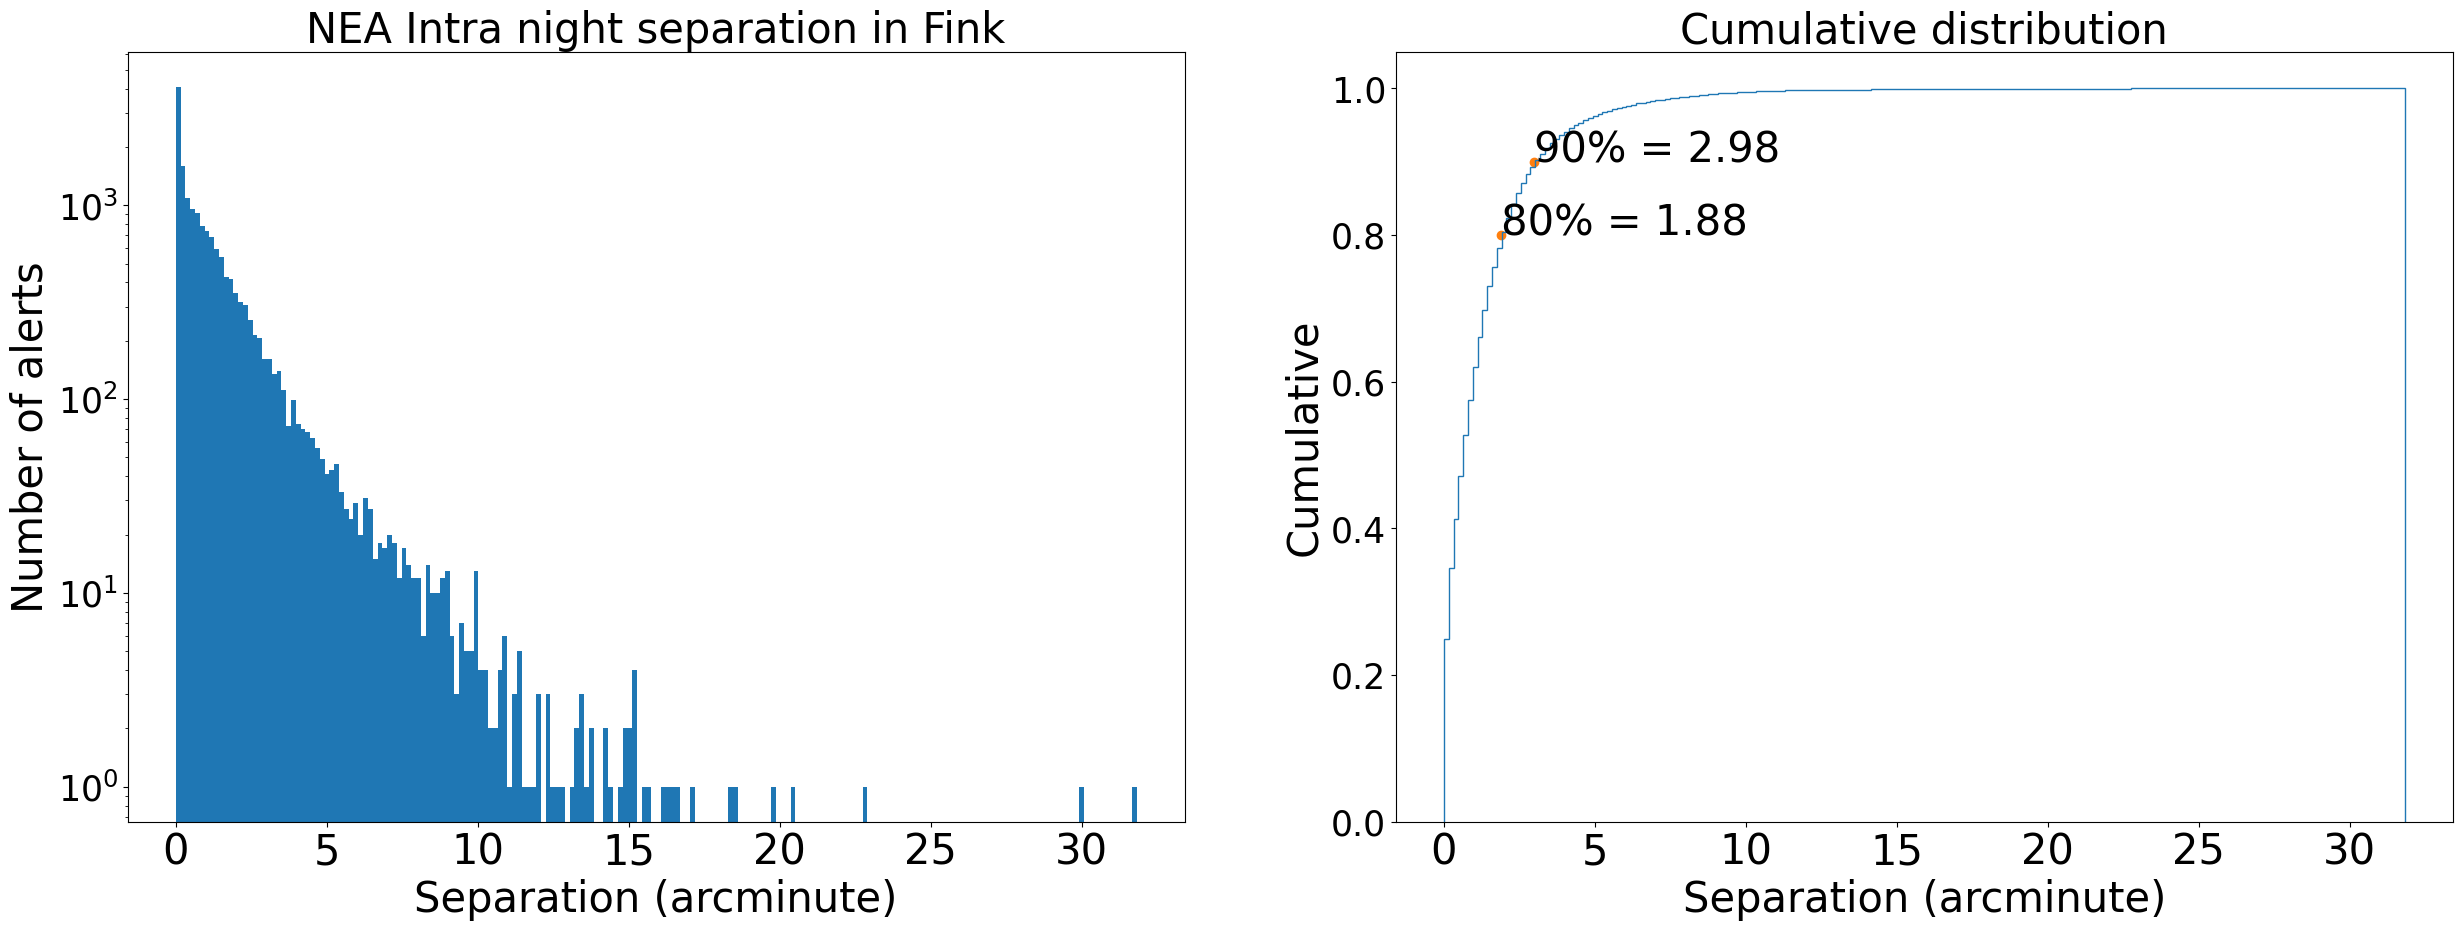

In [24]:
es.plot_hist_and_cdf(
    speed_intra_nea, 
    None, 
    "NEA Intra night separation in Fink", 
    "Separation (arcminute)", 
    "Number of alerts", 
    None, 
    "Cumulative distribution", 
    "Separation (arcminute)", 
    "Cumulative"
)